### Imports

In [1]:
import requests as rq
import pandas as pd
import numpy as np
import datetime as dt
import traceback as tb

from scipy import optimize
from scipy import integrate

### Download & plot data

In [2]:
# get daily time series data from covid19india
resp = rq.get("https://api.covid19india.org/data.json")
ts = resp.json()['cases_time_series']

r = {
    "date": [],
    "confirmed": [],
    "deceased": [],
    "recovered": []
}

for d in ts:
    try:
        r['date'].append(dt.datetime.strptime(d['date'] + "2020", '%d %B %Y'))
        r['confirmed'].append(np.int64(d['dailyconfirmed']))
        r['deceased'].append(np.int64(d['dailydeceased']))
        r['recovered'].append(np.int64(d['dailyrecovered']))
    except Exception as e:
        print(d['date'])
        tb.print_exc()

df = pd.DataFrame(r)
df.sort_values('date', inplace=True)

In [3]:
df.head()

,date,confirmed,deceased,recovered
0,2020-01-30,1,0,0
1,2020-01-31,0,0,0
2,2020-02-01,0,0,0
3,2020-02-02,1,0,0
4,2020-02-03,1,0,0


In [4]:
# remove first 37 days of data. not consequential.
fdf = df[37:][:]
fdf.reset_index(drop=True, inplace=True)
fdf['dailyactive'] = fdf['confirmed'] - fdf['recovered'] - fdf['deceased']
fdf['active'] = fdf['dailyactive'].cumsum()
fdf.head()

,date,confirmed,deceased,recovered,dailyactive,active
0,2020-03-07,3,0,0,3,3
1,2020-03-08,5,0,0,5,8
2,2020-03-09,9,0,0,9,17
3,2020-03-10,15,0,1,14,31
4,2020-03-11,8,0,0,8,39


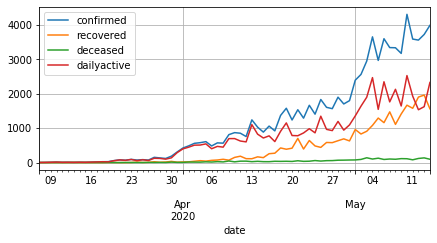

In [6]:
# plot downloaded data
fdf.plot(
    x='date',
    y=['confirmed', 'recovered', 'deceased', 'dailyactive'],
    figsize=(7,3),
    grid=True
)

### Compute & plot Re (effective reproduction number)

In [7]:
fdf['sma_confirmed'] = fdf['confirmed'].rolling(7, min_periods=1, center=True).mean().rolling(7, min_periods=1, center=True).mean()
fdf['re'] = fdf['sma_confirmed'] / fdf['sma_confirmed'].shift(1, fill_value=1)
#fdf['sma_re'] = fdf['re'].rolling(7, min_periods=1, center=True).mean().rolling(7, min_periods=1, center=True).mean()
fdf.tail()

,date,confirmed,deceased,recovered,dailyactive,active,sma_confirmed,re
64,2020-05-10,4311,112,1669,2530,43965,3619.182993,1.021990
65,2020-05-11,3592,81,1579,1932,45897,3652.371769,1.009170
66,2020-05-12,3562,120,1905,1537,47434,3681.719444,1.008035
67,2020-05-13,3726,137,1963,1626,49060,3705.920476,1.006573
68,2020-05-14,3991,97,1564,2330,51390,3737.793452,1.008601


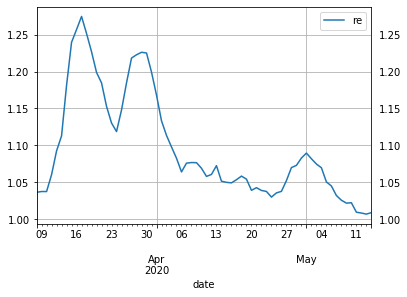

In [8]:
ax = fdf[1:].plot(
    x='date',
    y=['re'],
    grid=True
)
ax.tick_params(labeltop=False, labelright=True)

### Learning to fit a sample curve

In [9]:
# define a simple function
def y(x, a, b):
    return a * x * x + b

# generate multiplier between 0.9 and 1.1 to noisy test data for fitting
import random
def m():
    return 0.9 + 0.2 * random.random()

test_data = [2 * x * x * m() + 10 for x in range(10)] # so a=2 and b=10 in test data
print("actual output:", [f"{y(i, 2, 10):0.2f}" for i in range(10)])
print("values to fit:", [f"{i:0.2f}" for i in test_data])

# fit test data to function and try to find params
out = optimize.curve_fit(y, np.arange(10), test_data)
print ("param:", out[0])
print ("covar:\n", out[1])

actual output: ['10.00', '12.00', '18.00', '28.00', '42.00', '60.00', '82.00', '108.00', '138.00', '172.00']
values to fit: ['10.00', '11.93', '18.07', '27.59', '43.37', '59.26', '86.00', '103.02', '129.27', '157.82']
param: [ 1.84293543 12.11006633]
covar:
 [[ 1.50271881e-03 -4.28274867e-02]
 [-4.28274867e-02  2.30411870e+00]]


### SIR Model

In [10]:
def diff_eqns(y, t, beta, gamma, N):
    St, It, Rt = y
    dsdt = -beta * St * It / N
    didt = beta * St * It / N - gamma * It
    drdt = gamma * It
    return [dsdt, didt, drdt]

def sir_model(t, beta, gamma, I0, N):
    S0 = N - I0
    R0 = 0
    out = integrate.odeint(diff_eqns, (S0, I0, R0), t, args=(beta, gamma, N))
    S, I, R = out.T
    return S, I, R

### Sample plot of SIR model

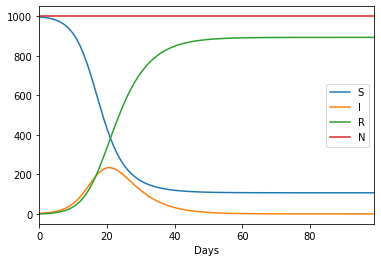

In [11]:
I0 = 3
N = 1000
beta = 0.5
gamma = 0.2
days = np.arange(100)
S, I, R = sir_model(days, beta, gamma, I0, N)

r = {
    'Days': days,
    'S': S,
    'I': I,
    'R': R
}

df = pd.DataFrame(r)
df['N'] = df['S'] + df['I'] + df['R']

df.plot(
    'Days',
    ['S', 'I', 'R', 'N']
)

### Try to fit the sample output back

In [12]:
def sir_model_apartment_inf(days, beta, gamma):
    I0 = 3
    N = 1000
    I = sir_model(days, beta, gamma, I0, N)[1]
    return I

days = np.arange(100)
I = sir_model_apartment_inf(days, 0.5, 0.2)
optimize.curve_fit(sir_model_apartment_inf, df['Days'], I)

(array([0.5, 0.2]), array([[4.23127455e-34, 1.88000344e-34],
        [1.88000344e-34, 2.08497191e-34]]))

### Try to fit India's data

/home/mayank/Apps/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/mayank/Apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mayank/Apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.


beta, gamma: [20.40779415 20.23565252]
covariance:
 [[0.15854073 0.15826358]
 [0.15826358 0.1579884 ]]
r0: 1.0085068487782933


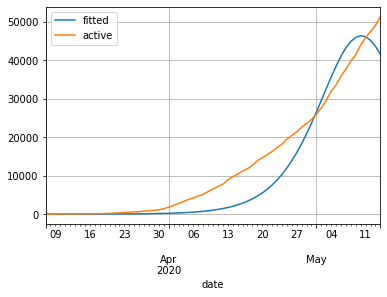

In [13]:
def sir_model_india_active(days, beta, gamma):
    I0 = 3 #mar 3
    N = 1300000000 #130 crores
    I = sir_model(days, beta, gamma, I0, N)[1]
    return I

def sir_model_india_removed(days, beta, gamma):
    I0 = 3 #mar 3
    N = 1300000000 #130 crores
    R = sir_model(days, beta, gamma, I0, N)[2]
    return R

to_fit = sir_model_india_active
params, cov = optimize.curve_fit(to_fit, fdf.index, fdf.active) # fdf.recovered + fdf.deceased)

print("beta, gamma:", params)
print("covariance:\n", cov)
print("r0:", params[0]/params[1])

fdf['fitted'] = to_fit(fdf.index, *params)
ax = fdf.plot(
    x='date',
    y='fitted'
)
fdf.plot(
    x='date',
    y='active',
    grid=True,
    ax=ax
)

### Project peak per the fitted curve

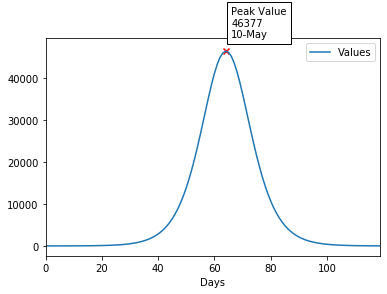

In [16]:
days = np.arange(120)
vals = to_fit(days, *params)
r = {
    'Days': days,
    'Values': vals
}
df = pd.DataFrame(r)
ax = df.plot(
    x='Days',
    y='Values'
)

peakx = 64
peak_date = (dt.datetime(day=7, month=3, year=2020) + dt.timedelta(days=peakx)).strftime("%d-%b")
ax.scatter([peakx], [df['Values'].iloc[peakx]], c='red', marker='x')
_ = ax.text(
    peakx + 2,
    df['Values'].iloc[peakx] * 1.07,
    "Peak Value\n" + str(int(df['Values'].iloc[peakx])) + "\n" + peak_date, 
    bbox={'facecolor':'white'}
)

### Try to fit Italy's data

In [17]:
# download italy's data
it_df = pd.read_csv("csv/italy.csv", parse_dates=['date'])
it_df.head()

,date,deceased,recovered,confirmed,active
0,2020-02-21,1,NaN,20,19
1,2020-02-22,2,2.0,79,75
2,2020-02-23,3,2.0,150,145
3,2020-02-24,6,1.0,229,222
4,2020-02-25,10,1.0,322,311


beta: [2.44076375 2.27480683]
r0: 1.0729542900779165


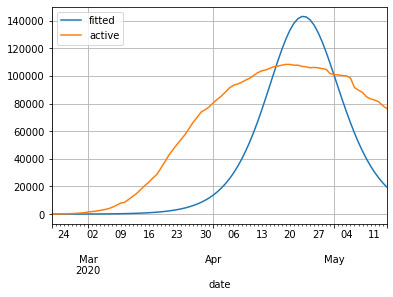

In [18]:
def sir_model_italy_active(days, beta, gamma):
    I0 = 19 #active cases on 21 feb
    N = 60461826 #6 crores
#     gamma = 0.1
    I = sir_model(days, beta, gamma, I0, N)[1]
    return I

to_fit = sir_model_italy_active
params, cov = optimize.curve_fit(
    to_fit,
    it_df.index,
    it_df.active,
#     bounds=[(0, 0), (np.inf, 1)]
)

print("beta:", params)
# print("covariance:\n", cov)
print("r0:", params[0]/params[1])

it_df['fitted'] = to_fit(it_df.index, *params)
ax = it_df.plot(
    x='date',
    y='fitted'
)
_ = it_df.plot(
    x='date',
    y='active',
    grid=True,
    ax=ax
)